In [293]:
"""
This notebook evaluates the performance of different filters for
image segmentation of the spectrogram produced by the PyBirales
Channeliser. 

Notebook reproduces the figures used in the 
streak detection paper.

"""

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
from astropy.io import fits
from astropy.table import Table
import seaborn as sns
import os

%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 10)

In [294]:
from skimage import data
from skimage.filters import try_all_threshold
from skimage.filters import threshold_otsu, threshold_local
from skimage.filters import median

In [295]:
ROOT = "/home/denis/.birales/visualisation/fits"
OUT_DIR = "/home/denis/.birales/visualisation/analysis"
FITS_FILE = "norad_1328/norad_1328_raw_1.fits"
SAVE_FIGURES = False
TX = 410.085e6
BNDW = 0.078125e6
START_FREQ = 410.0425e6
END_FREQ = 410.0425e6 + BNDW
N_CHANS = 8192
SAMPLING_RATE = 78125
TD = 1./ SAMPLING_RATE
OBS_NAME = "NORAD_1328"

In [296]:
fits_file = fits.open(os.path.join(ROOT, FITS_FILE))

In [297]:
image_data = fits_file[0].data[0]

print ('Data shape: {} channels and {} samples'.format(image_data.shape[0], image_data.shape[1]))

def save_figure(filename):
    if SAVE_FIGURES:
        plt.savefig(os.path.join(OUT_DIR, OBS_NAME, filename, '.pdf'))

Data shape: 8192 channels and 1600 samples


Image Data reduced to: 300 channels and 100 samples


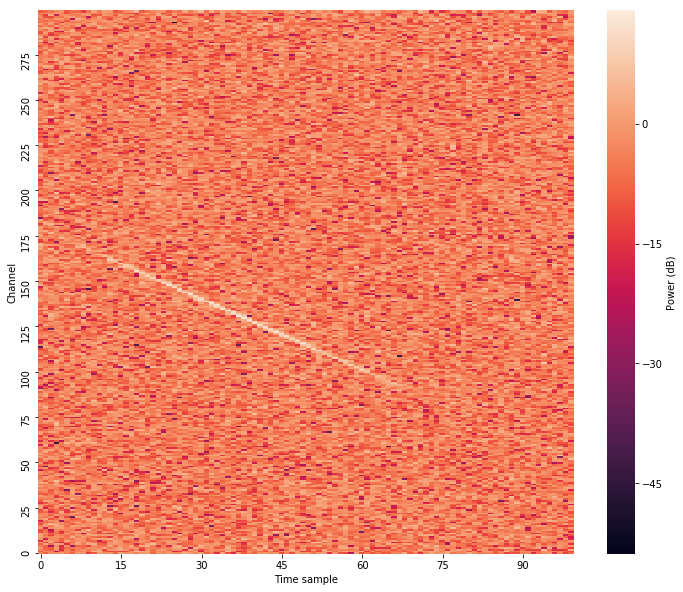

In [298]:
time_samples = np.arange(0, image_data.shape[1])
channel_samples = np.arange(0, N_CHANS)

time = time_samples * TD
channels = np.linspace(start=START_FREQ, stop=END_FREQ, num=N_CHANS)

# Choose what subset of the image data to show (c0, cn, t0, tn)
SUBSET = (4100, 4400, 800, 900)
subset_data = image_data[SUBSET[0]:SUBSET[1], SUBSET[2]:SUBSET[3]]
print ('Image Data reduced to: {} channels and {} samples'.format(subset_data.shape[0], subset_data.shape[1]))

ax0 = sns.heatmap(subset_data, cbar_kws={'label': 'Power (dB)'}, 
#                   square=True, 
                  xticklabels=15, 
                  yticklabels=25)
ax0.invert_yaxis()
ax0.set(xlabel='Time sample', ylabel='Channel')   

save_figure('before_filter')

Noise: -4.80 dB, Thres: 6.34 dB (~SNR: -1.34 dB)


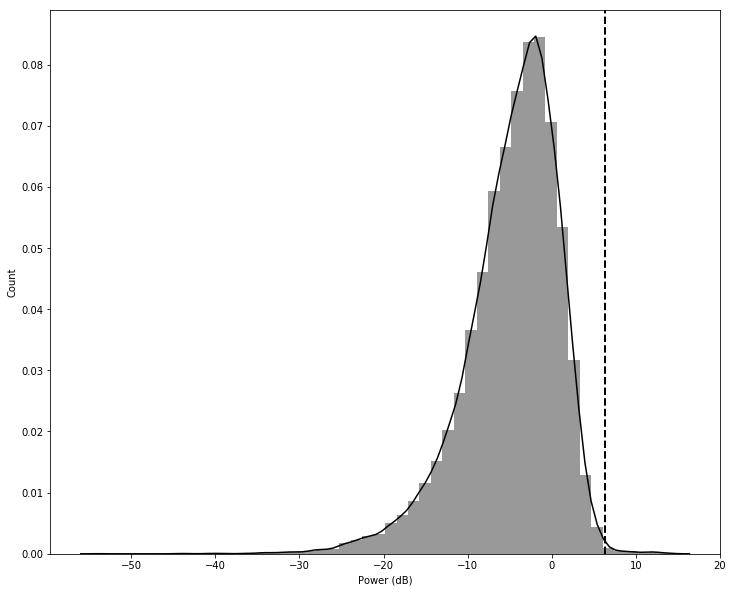

In [307]:
# Background noise filter: Show noise distribution (histogram) before and after filter is applied
def threshold(data):
    channel_noise = np.mean(data, axis=1)
    std = np.std(data, axis=1)
    
    threshold = 2 * std + channel_noise    

    return channel_noise, threshold

channel_noise, threshold = threshold(subset_data)
print('Noise: {:0.2f} dB, Thres: {:0.2f} dB (~SNR: {:0.2f} dB)'.format(np.mean(channel_noise), np.mean(threshold), np.mean(threshold/channel_noise)))

ax1 = sns.distplot(subset_data.flatten(), color='black')
ax1.set(xlabel='Power (dB)', ylabel='Count')   
ax1.axvline(x=np.mean(threshold), ymin=0, ymax=1, linewidth=2,linestyle='dashed', color='black')

save_figure('noise_distribution')

In [310]:
def visualise_filter(data, mask, threshold, filename):
    ax = sns.heatmap(data, cbar_kws={'label': 'Power (dB)'},                   
                  xticklabels=25, 
                  yticklabels=25,
                  mask=mask
                 )
    ax.invert_yaxis()
    ax.set(xlabel='Time sample', ylabel='Channel')   
    
    print('Noise: {:0.2f} dB, Thres: {:0.2f} dB (~SNR: {:0.2f} dB)'.format(np.mean(data), np.mean(threshold), np.mean(threshold/np.mean(data))))

    save_figure(filename)
    

Noise: -4.80 dB, Thres: 6.34 dB (~SNR: -1.32 dB)


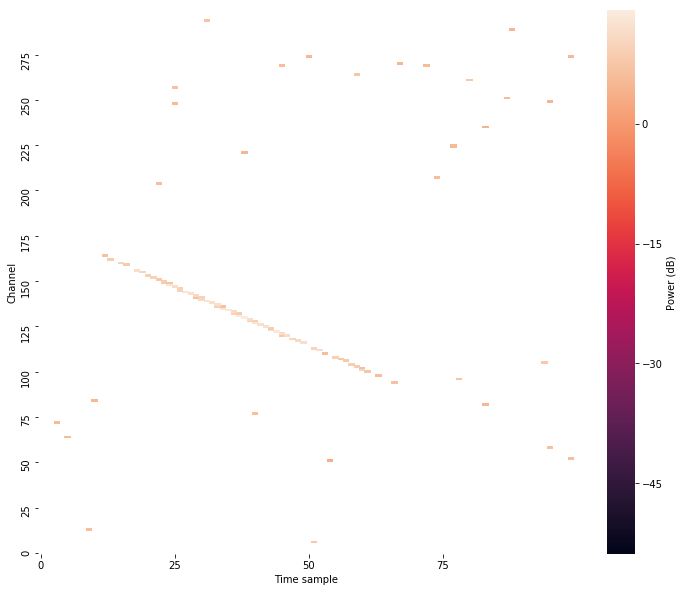

In [312]:
"Test median filter"
bf_filter_mask = np.where(subset_data<np.expand_dims(threshold, axis=1), subset_data, 0)
visualise_filter(subset_data, bf_filter_mask, threshold, 'after_bf_filter')

Noise: -4.80 dB, Thres: -6.65 dB (~SNR: 1.39 dB)


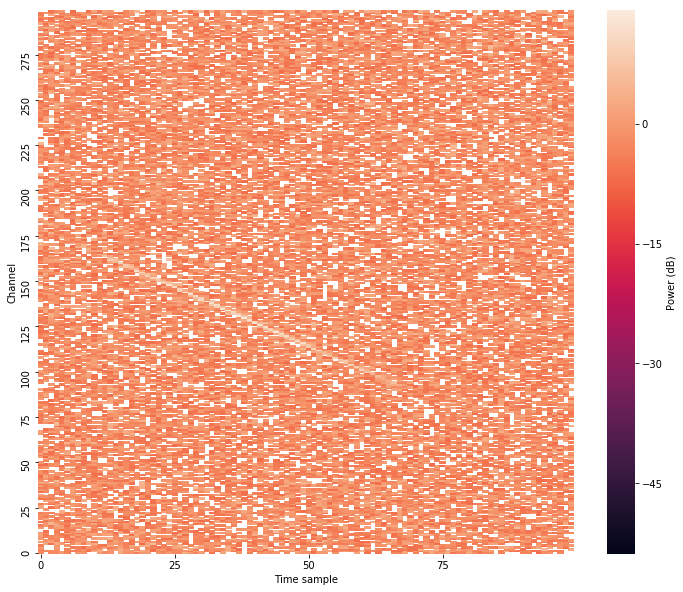

In [316]:
"Test the global Otsu thresholding"
global_thresh = threshold_otsu(subset_data)
global_filter_mask = np.where(subset_data<global_thresh, subset_data, 0)
visualise_filter(subset_data, global_filter_mask,global_thresh, 'after_global_otsu_filter')

Noise: -4.80 dB, Thres: -6.80 dB (~SNR: 1.42 dB)


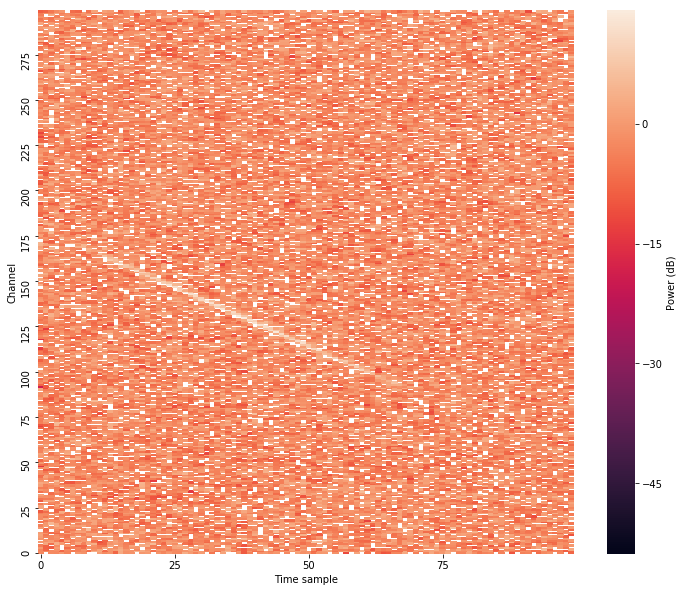

In [315]:
"Test an adaptive filter"
block_size = 5
local_thresh = threshold_local(subset_data, block_size, offset=2)
local_filter_mask = np.where(subset_data < local_thresh, subset_data, 0)
visualise_filter(subset_data, local_filter_mask,local_thresh, 'after_local_filter')

14.233491897583008


[Text(87,0.5,'Channel'), Text(0.5,69,'Time sample')]

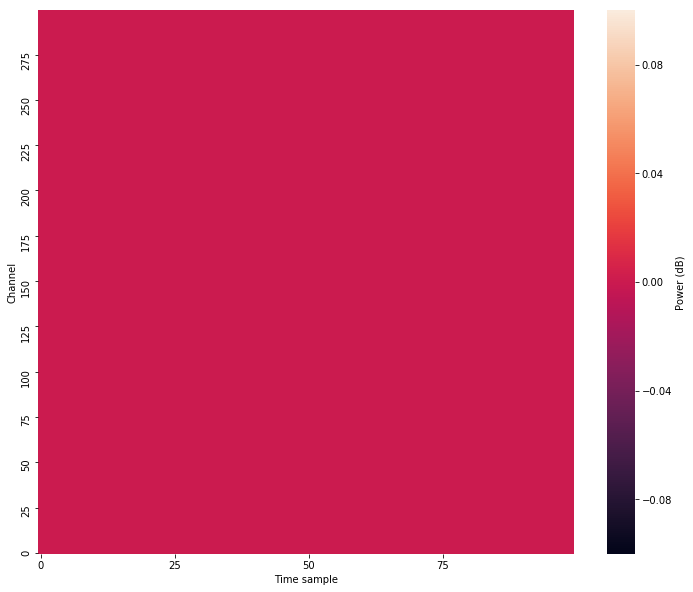

In [314]:
"Test median filter"
from scipy import ndimage
filtered_data = np.array(subset_data, copy=True)  
filtered_data[filtered_data <= np.expand_dims(threshold, axis=1)] = 0

filtered_med = ndimage.median_filter(filtered_data, 20)
# visualise_filter(subset_data, local_filter_mask,local_thresh, 'after_local_filter')
print np.max(filtered_data)
ax = sns.heatmap(filtered_med, cbar_kws={'label': 'Power (dB)'},                   
                  xticklabels=25, 
                  yticklabels=25)
ax.invert_yaxis()
ax.set(xlabel='Time sample', ylabel='Channel')   

In [617]:
from sklearn.metrics import jaccard_similarity_score

def calculate_amplitude(noise_std, snr):
    """

    :param noise_std:
    :param snr:
    :return:
    """
    noise_avg_watts = noise_std ** 2
    noise_avg_db = 10 * np.log10(noise_avg_watts)

    signal_avg_db = noise_avg_db + snr
    sig_avg_watts = 10 ** (signal_avg_db / 10)

    # we can use this as amplitude for our chirp
    return np.sqrt(sig_avg_watts)

def generate_noise(mean_noise_power, std, n_samples):    
    return np.random.normal(loc=mean_noise_power, scale=std, size=n_samples)

def visualise_image(image):
    # Visualise the test data
    ax = sns.heatmap(image, cbar_kws={'label': 'Power (dB)'},                   
                      xticklabels=25, 
                      yticklabels=25)
    ax.invert_yaxis()
    ax.set(xlabel='Time sample', ylabel='Channel')  
    
def uniform(min_max_range):
    return np.random.uniform(min_max_range[0], min_max_range[1])

def create_track(x, gradient, intercept, img_shape):
    y = x*gradient + intercept
    y[y <= 0] = 0
    y[y >= img_shape[0]] = img_shape[0]-1
    return y.astype(int)

def create_test_image(filepath):
    fits_file = fits.open(filepath)
    test_image = fits_file[0].data[0][8000:, 1400:]
    print 'Test Image of size {} was generated'.format(test_image.shape)

    return test_image

def jaccard(true_image, filtered_image):
    true_image=np.array(true_image).ravel()
    filtered_image=np.array(filtered_image).ravel()
    return jaccard_similarity_score(true_image, filtered_image)

def get_test_tracks(n_tracks, gradient, track_start, image_shape, noise_mean, snr):
    tracks = []
    for i in range(0, n_tracks):
        m = uniform(gradient)
        start = np.random.randint(low=track_start[0], high=track_start[1])
        end = np.random.randint(low=start, high=image_shape[1])
        x = np.arange(start,  end)
        c = np.random.randint(low=100, high=image_shape[0])
        y = create_track(x, m, c, image_shape)

        print 'Created track with m={:0.2f}, c={:0.2f}, of {} pixels at x={} with SNR={:0.2f} dB'.format(m,c,(max(x)-start), start, SNR)

#         image[y, x] += calculate_amplitude(noise_std=NOISE_MEAN, snr=SNR) 
        
        tracks.append((x, y, calculate_amplitude(noise_std=noise_mean, snr=snr)))
    return tracks

(192, 168)
Test Image of size (192, 168) was generated with a Noise value of -2.91 dB and std of 5.68 dB
Created track with m=-0.40, c=161.00, of 27 pixels at x=96 with SNR=20.00 dB
96 123 112 122
Created track with m=-0.08, c=191.00, of 9 pixels at x=27 with SNR=20.00 dB
27 36 188 188
Created track with m=-0.11, c=132.00, of 141 pixels at x=8 with SNR=20.00 dB
8 149 115 131
Created track with m=-0.07, c=104.00, of 88 pixels at x=36 with SNR=20.00 dB
36 124 95 101
Created track with m=-0.30, c=114.00, of 14 pixels at x=104 with SNR=20.00 dB
104 118 78 83


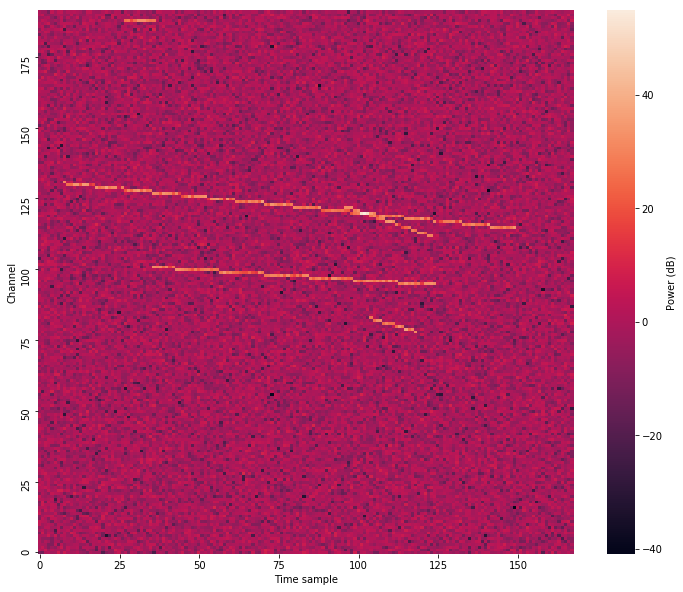

In [616]:
"Evaluation of the filters implemented"

np.random.seed(56789)

NOISE_MEAN = np.mean(image_data)
NOISE_STD = np.std(image_data)
# IMAGE_SHAPE = (500, 300) # channels against time

SNR = 20
N_TRACKS = 5
TD = 262144/78125/32.
CD = 78125/8192.
F = (1./TD) / (1./CD)
GRADIENT_RANGE = np.array([-0.57, -50.47]) / F
SNR_RANGE = [5, 50]
TRACK_LENGTH_RANGE = np.array([5, 15])/TD # in seconds
TRACK_START = np.array([0, 10])/TD # in seconds
FITS_FILE = "norad_1328/norad_1328_raw_0.fits"

# Create image from real data
test_image = create_test_image(os.path.join(ROOT, FITS_FILE))
IMAGE_SHAPE = test_image.shape


tracks = get_test_tracks(N_TRACKS, GRADIENT_RANGE, TRACK_START, IMAGE_SHAPE, NOISE_MEAN, STD)
visualise_image(image)

In [ ]:
true_image = np.zeros(shape=np.shape(image))

img_true=np.array(img_true).ravel()
img_pred=np.array(img_pred).ravel()
iou = jaccard_similarity_score(img_true, img_pred)